<a href="https://colab.research.google.com/github/preetamjumech/Autoencoder_cnn-and-VAE/blob/main/Preetam_Saha_AutoEncoder_CNN_03_09_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam 
import matplotlib.pyplot as plt

#cnn autoencoder with noise removal

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
!wget https://github.com/MorvanZhou/PyTorch-Tutorial/raw/master/tutorial-contents-notebooks/mnist/processed/training.pt
!wget https://github.com/MorvanZhou/PyTorch-Tutorial/raw/master/tutorial-contents-notebooks/mnist/processed/test.pt

--2022-10-04 07:12:22--  https://github.com/MorvanZhou/PyTorch-Tutorial/raw/master/tutorial-contents-notebooks/mnist/processed/training.pt
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MorvanZhou/PyTorch-Tutorial/master/tutorial-contents-notebooks/mnist/processed/training.pt [following]
--2022-10-04 07:12:23--  https://raw.githubusercontent.com/MorvanZhou/PyTorch-Tutorial/master/tutorial-contents-notebooks/mnist/processed/training.pt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47520431 (45M) [application/octet-stream]
Saving to: ‘training.pt’

training.pt         100%[===================>]

In [4]:
x_train, _ = torch.load("training.pt") #for auto encoder, we dont need y_train, we are using MNIST data, training will be faster

In [5]:
x_train.shape

torch.Size([60000, 28, 28])

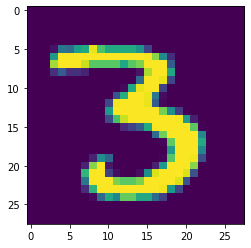

In [6]:
plt.imshow(x_train[12]) #image without the normalization

In [7]:
def normalize(x):
  max_val = x.max()
  min_val = x.min()
  return (x-min_val)/(max_val - min_val)

In [8]:
#x_train = normalize(x_train)

In [9]:
x_train.shape #28*28 is a single image, shape remaining same, only values are getting normalized 

torch.Size([60000, 28, 28])

In [10]:
def salt_n_pepper_noise(x):
  return x+torch.rand(x.size())

def gaussian_noise(x):
  return x+torch.normal(0,0.15,size=x.size()) #mean = 0, sd = 0.15 , if sd is of higher value, the clipping would happen , value will be clipped at 1

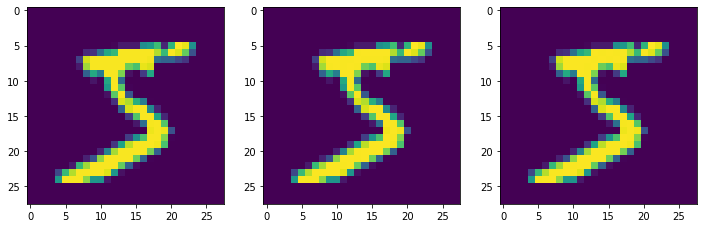

In [11]:
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(x_train[0])
plt.subplot(1,3,2)
plt.imshow(salt_n_pepper_noise(x_train[0]))
plt.subplot(1,3,3)
plt.imshow(gaussian_noise(x_train[0])) #even some noises are added, we dont see any kind of differences, if we DONT do NORMALIZATION

In [12]:
x_train = normalize(x_train)

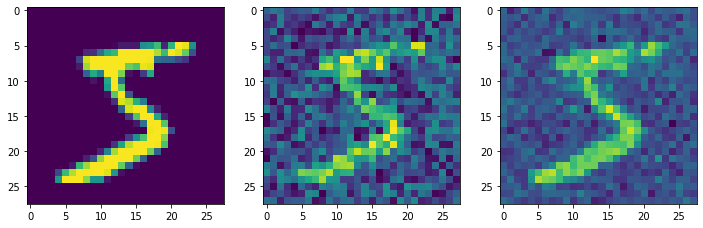

In [13]:
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(x_train[0])
plt.subplot(1,3,2)
plt.imshow(salt_n_pepper_noise(x_train[0]))
plt.subplot(1,3,3)
plt.imshow(gaussian_noise(x_train[0])) #after normalizing

In [14]:
x_train_sp_noise = salt_n_pepper_noise(x_train) #x_train is tensor here, big brother of array 
#x_train_gauss_noise = gaussian_noise(x_train)

In [15]:
#input = x_train_sp_noise (with noise), output = x_train (de-noising) which is required to be supplied
batch_size = 512
train_loader = DataLoader(TensorDataset(x_train_sp_noise.reshape(-1,1,28,28).float(),
                                        x_train.reshape(-1,1,28,28).float()),
                          batch_size=512,shuffle=True)

In [16]:
class AE_CNN(nn.Module):
  def __init__(self):
    super(AE_CNN,self).__init__()

    self.enc_cv1 = nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.enc_cv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)

    self.dec_cv2 = nn.ConvTranspose2d(in_channels=64,out_channels=32,stride =2,kernel_size=2)
    self.dec_cv3 = nn.ConvTranspose2d(in_channels=32,out_channels=1,stride =2,kernel_size=2)

  def encoder(self,x):
    x = F.relu(self.enc_cv1(x)) #size = 28x28
    x = self.pool(x) #size = 14x14
    x = F.relu(self.enc_cv2(x)) #size = 14x14
    x = self.pool(x) #size = 7x7 #at the constraint or bottleneck part, image size is 7x7

    return x

  def decoder(self,x):
    x = F.relu(self.dec_cv2(x)) #size = 14x14
    x = self.dec_cv3(x) #size = 28x28 

    return x 

  def forward(self,x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [17]:
model = AE_CNN()

In [18]:
list(model.parameters())

[Parameter containing:
 tensor([[[[ 0.2621, -0.0634, -0.0238],
           [-0.1955,  0.1217,  0.2712],
           [-0.1256, -0.1023,  0.1307]]],
 
 
         [[[ 0.2566,  0.0421,  0.2323],
           [-0.3316,  0.2411, -0.1513],
           [ 0.2022,  0.1113,  0.2608]]],
 
 
         [[[ 0.3140, -0.2720,  0.2620],
           [ 0.2334, -0.0635, -0.2060],
           [-0.1623, -0.2137,  0.1466]]],
 
 
         [[[ 0.2641,  0.1388, -0.0605],
           [-0.1469, -0.0220, -0.1952],
           [-0.0544, -0.1853, -0.2046]]],
 
 
         [[[-0.2197, -0.2884,  0.2587],
           [ 0.1775, -0.1847,  0.1736],
           [ 0.1336, -0.1533, -0.2579]]],
 
 
         [[[ 0.1717,  0.2783,  0.3027],
           [ 0.3204,  0.1715, -0.0044],
           [ 0.0944,  0.1540,  0.1370]]],
 
 
         [[[-0.2954, -0.0170, -0.0553],
           [-0.1737, -0.1672,  0.1002],
           [-0.0764,  0.2882, -0.2354]]],
 
 
         [[[-0.2993, -0.1521,  0.0414],
           [-0.2391, -0.0083, -0.1383],
           [ 0.

In [19]:
opt = Adam(model.parameters())
max_epoch = 10
model = model.to(device)

for epoch in range(max_epoch):
  training_loss = 0.0

  for data, target in train_loader:
    data = data.to(device)
    target = target.to(device)

    opt.zero_grad()

    output = model(data)

    loss = F.mse_loss(output, target)
    loss.backward()

    opt.step()

    training_loss += loss.item()

  if (epoch+1)%2 == 0:
    print("epoch: {} training loss : {}".format(epoch+1,training_loss))

epoch: 2 training loss : 1.966891153715551
epoch: 4 training loss : 1.391926234588027
epoch: 6 training loss : 1.1925505688413978
epoch: 8 training loss : 1.0904792752116919
epoch: 10 training loss : 1.026395377703011


In [20]:
x_test, _ = torch.load("test.pt")

In [21]:
img_id = 100
test1 = x_test[img_id]
test1_noise = salt_n_pepper_noise(normalize(test1.reshape(-1,1,28,28))) #here we are supplyinhy noised images as input (test data)
test1_output = model(test1_noise.float().to(device)) #denoised image

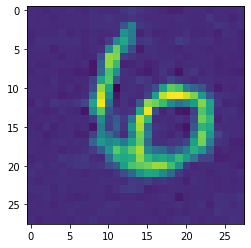

In [22]:
plt.imshow(test1_output.cpu().detach().numpy().reshape(28,28)) #denoised image , so noise is quite efficiently removed in this image

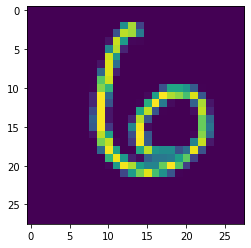

In [23]:
plt.imshow(x_test[100])

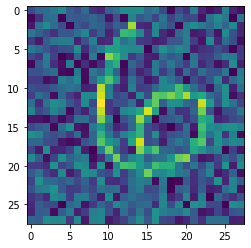

In [24]:
plt.imshow(test1_noise.reshape(28,28)) #original noised data

#VAE

In [25]:
bs = 512
train_loader_vae = DataLoader(TensorDataset(x_train.reshape(-1,1,28,28).float(),x_train.reshape(-1,1,28,28).float()),
                              batch_size=bs,shuffle=True)

In [26]:
class VAE(nn.Module):
  def __init__(self):
    super(VAE,self).__init__()

    self.enc_cv1 = nn.Conv2d(in_channels=1,out_channels=4*8,kernel_size=4,padding=1,stride=2) #14x14
    self.enc_cv2 = nn.Conv2d(in_channels=4*8,out_channels=8*8,kernel_size=4,padding=1,stride=2) #7x7
    self.enc_cv3 = nn.Conv2d(in_channels=8*8,out_channels=16*8,kernel_size=3,padding=0,stride=2) #3x3
    self.enc_cv4 = nn.Conv2d(in_channels=16*8,out_channels=32*8,kernel_size=2,padding=0,stride=2) #1x1
    
    self.enc_mean = nn.Linear(in_features=32*8,out_features=20)
    self.enc_var = nn.Linear(in_features=32*8,out_features=20)
    
    self.dec_fc = nn.Linear(in_features=20,out_features=32*8)
    self.dec_cv2 = nn.ConvTranspose2d(in_channels=32*8,out_channels=16*8,stride =2,kernel_size=3,padding=0) #3x3
    self.dec_cv3 = nn.ConvTranspose2d(in_channels=16*8,out_channels=8*8,stride =2,kernel_size=3,padding=0) #7x7
    self.dec_cv4 = nn.ConvTranspose2d(in_channels=8*8,out_channels=4*8,stride =2,kernel_size=4,padding=1) #14x14
    self.dec_cv5 = nn.ConvTranspose2d(in_channels=4*8,out_channels=1,stride =2,kernel_size=4,padding=1) #28x28

  def encoder(self,x):
    x = F.relu(self.enc_cv1(x))
    x = F.relu(self.enc_cv2(x))
    x = F.relu(self.enc_cv3(x))
    x = F.relu(self.enc_cv4(x))

    x = x.view(x.size()[0],-1) #flattening it

    mu = self.enc_mean(x)
    log_var = self.enc_var(x) #for our own reference, this is nothing but a neural netwrok 

    std = torch.exp(0.5*log_var)
    eps = torch.rand_like(std)
    z = mu + (eps*std)
    return z,mu,log_var

  def decoder(self,x):
    x = F.relu(self.dec_fc(x))
    x = x.reshape(-1,32*8,1,1)
    x = F.relu(self.dec_cv2(x))
    x = F.relu(self.dec_cv3(x))
    x = F.relu(self.dec_cv4(x))
    x = self.dec_cv5(x)
    return x 

  def forward(self,x):
    enc_out, mu, log_var = self.encoder(x)
    dec_out = self.decoder(enc_out)
    return dec_out, mu, log_var

In [27]:
model_vae = VAE()

In [28]:
model_vae = model_vae.to(device)

In [29]:
opt_vae =Adam(model_vae.parameters())

In [30]:
max_epoch = 100

for epoch in range(max_epoch):
  training_loss_vae = 0.0

  for data_vae, _ in train_loader_vae:
    data_vae = data_vae.to(device)

    opt_vae.zero_grad()

    output, mu, log_var = model_vae(data_vae)

    loss_vae = F.mse_loss(output, data_vae,reduction = "mean") - \
                0.5*torch.mean(1+log_var-mu.pow(2)-log_var.exp())*(1/(epoch+1))
    loss_vae.backward()
    opt_vae.step()

    training_loss_vae += loss_vae.item()

  if (epoch+1) % 20 ==0 :
    print("epoch: {} training loss : {}".format(epoch+1,training_loss_vae))

epoch: 20 training loss : 3.0477144345641136
epoch: 40 training loss : 2.281730178743601
epoch: 60 training loss : 1.9348421059548855
epoch: 80 training loss : 1.7193778567016125
epoch: 100 training loss : 1.5755185596644878


In [31]:
import numpy as np


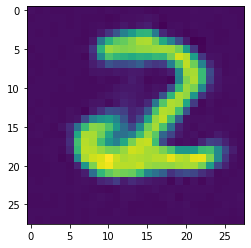

In [32]:
with torch.no_grad():
  noise = np.random.normal(0,1,size=20)
  noise = torch.from_numpy(noise).float().to(device)
  generated_images = model_vae.decoder(noise)
  plt.imshow(generated_images.cpu().detach().numpy().reshape(28,28))